<a href="https://colab.research.google.com/github/aidanjmaldonado/penny-stock-lstm/blob/main/penny_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import requests
import sys
import pytz

from library.DataSetProcessor import DataSetProcessor
import matplotlib.pyplot as plt

import pickle




In [2]:
dataSetProcessor = DataSetProcessor()

In [3]:
# Connect to SQlite database
try:
    db = 'historical.db'
    sqliteConnection = sqlite3.connect(db)
    cursor = sqliteConnection.cursor()
    print(f'SQlite connected with {db}')

except:
    sys.stderr.write("Failed to connect to database")

SQlite connected with historical.db


# Create database

In [4]:
# Query {ticker(s)} from Database
try:
    query = f"SELECT * FROM all_historical;"
    cursor.execute(query)
    if cursor.fetchone() is None:
        raise Exception("No results")

    print(f"Success querying all historical")
    # Turn SQlite Database into Pandas Dataframe
    data = pd.read_sql_query(query, sqliteConnection)

except:
    sys.stderr.write(f"Failed to select all historical")

Success querying all historical


In [5]:
# Using the column 'time' (millisecond) add a new column 'dates' with datetime

# def addDateAndMinutes(rawData: pd.DataFrame) -> pd.DataFrame:
#     data = rawData.copy()
#     dates = pd.to_datetime(data['time'], unit='ms')
#     dates = dates.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
#     dates = dates.dt.tz_localize(None)
#     data["date"] = dates.dt.date
#     data["timeTime"] = dates.dt.time
#     data["timeMinute"] = dates.dt.hour * 100 + dates.dt.minute
#     return data

data = dataSetProcessor.addDateAndMinutes(data)

In [6]:
data.head()

,id,ticker,volume,volume_weighted_average,open,close,high,low,time,number_of_trades,date,timeTime,timeMinute
0,1,ACHR,269.0,3.0307,3.0301,3.030,3.0301,3.0300,1657643400000,4,2022-07-12,09:30:00,930
1,2,ACHR,2037.0,3.0362,3.0400,3.040,3.0400,3.0350,1657643700000,35,2022-07-12,09:35:00,935
2,3,ACHR,796.0,3.0364,3.0400,3.035,3.0400,3.0350,1657644000000,17,2022-07-12,09:40:00,940
3,4,ACHR,1795.0,3.0356,3.0350,3.035,3.0400,3.0350,1657644300000,19,2022-07-12,09:45:00,945
4,5,ACHR,10397.0,3.0286,3.0350,3.025,3.0350,3.0212,1657644600000,87,2022-07-12,09:50:00,950


In [7]:
data['ticker'].unique()

array(['ACHR', 'SOUN', 'BITF', 'GSAT', 'PLUG', 'IAG', 'CHPT', 'PSNY',
       'BTBT', 'AAU', 'CDAK', 'CIDM', 'QNCX', 'AXXA', 'IVP', 'GTVH',
       'RONN', 'QLGN', 'VHAI', 'STSS', 'SMX', 'CBDD', 'SNOA', 'MICS',
       'ZAPP', 'MAXN', 'KTRA', 'BENF', 'RMSL', 'XHG', 'NEGG', 'EOSE',
       'SIRI'], dtype=object)

In [8]:
# sequences = dataSetProcessor.get5MinSequences(data, scale=True)

# with open('sequences.pickle', 'wb') as handle:
#     pickle.dump(sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# assert len(sequences) == len(data['ticker'].unique())

In [11]:
achrData = data[data['ticker'] == 'ACHR']
len(achrData)

26651

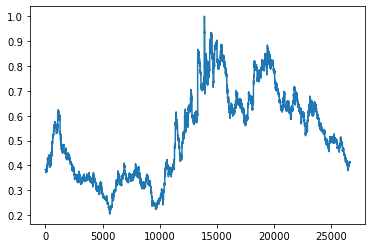

In [13]:
plt.plot(achrData['close'] / achrData['close'].max())

In [10]:
dataByTicker = {}
for ticker in data['ticker'].unique():
    dataByTicker[ticker] = data[data['ticker'] == ticker].copy()
    dataByTicker[ticker]['closeNorm'] = dataByTicker[ticker]['close'] / dataByTicker[ticker]['close'].max()
    dataByTicker[ticker]['volumeNorm'] = dataByTicker[ticker]['volume'] / dataByTicker[ticker]['volume'].max()

In [18]:
dataByTicker.keys()

dict_keys(['ACHR', 'SOUN', 'BITF', 'GSAT', 'PLUG', 'IAG', 'CHPT', 'PSNY', 'BTBT', 'AAU', 'CDAK', 'CIDM', 'QNCX', 'AXXA', 'IVP', 'GTVH', 'RONN', 'QLGN', 'VHAI', 'STSS', 'SMX', 'CBDD', 'SNOA', 'MICS', 'ZAPP', 'MAXN', 'KTRA', 'BENF', 'RMSL', 'XHG', 'NEGG', 'EOSE', 'SIRI'])

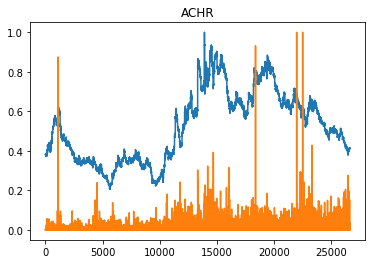

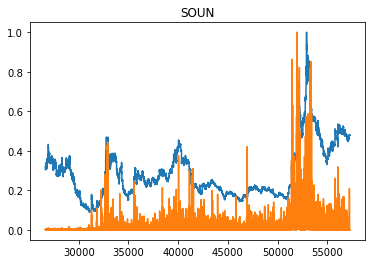

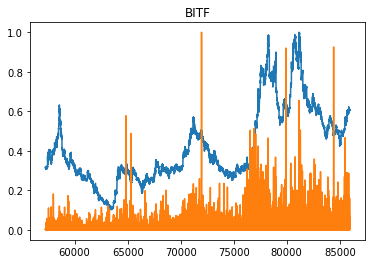

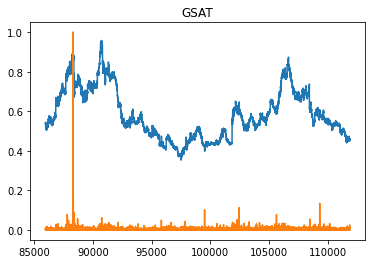

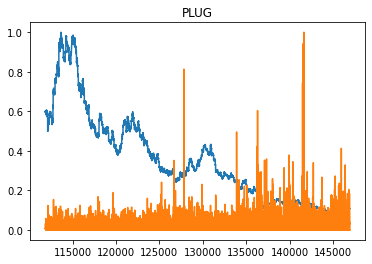

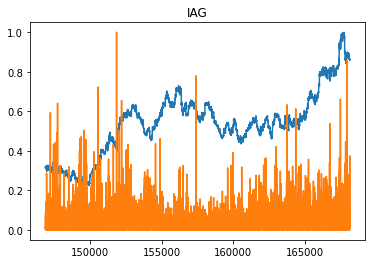

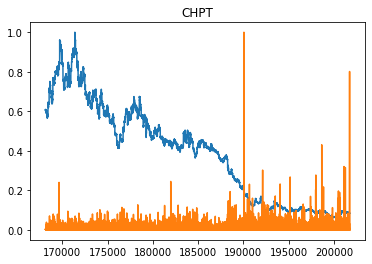

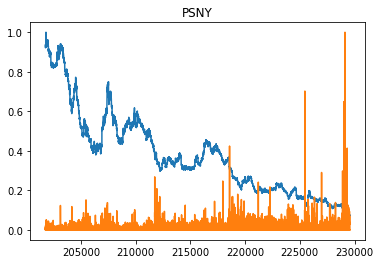

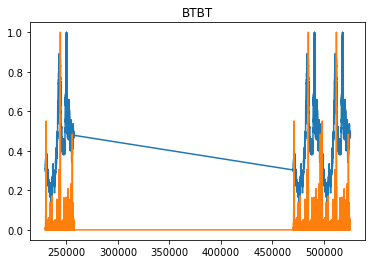

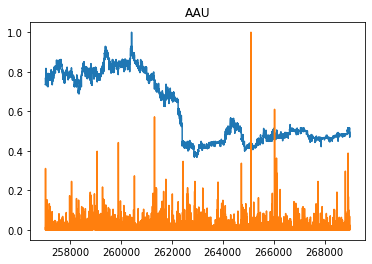

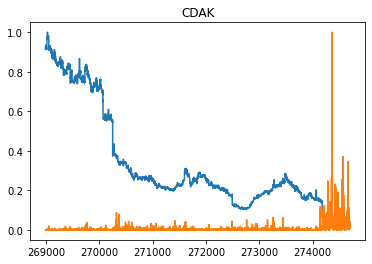

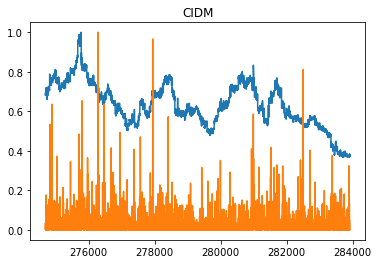

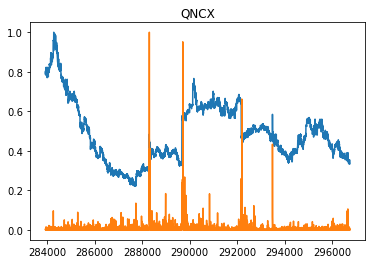

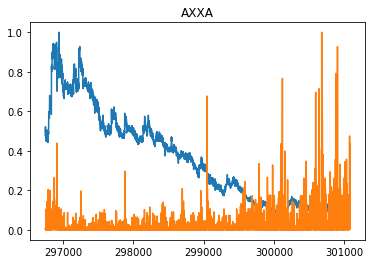

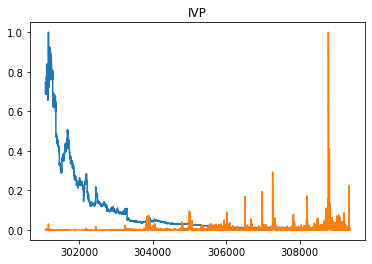

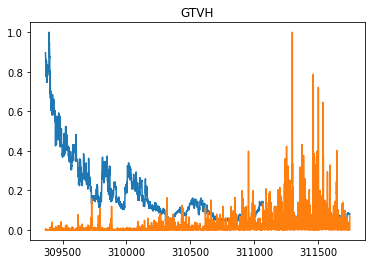

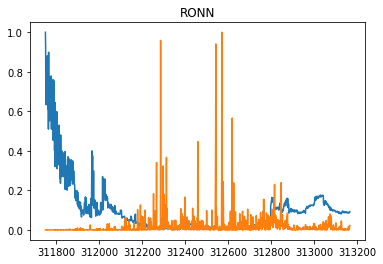

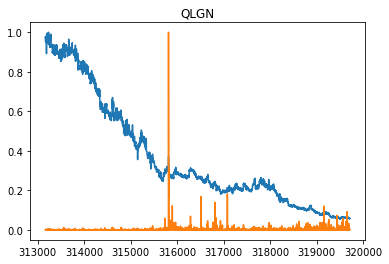

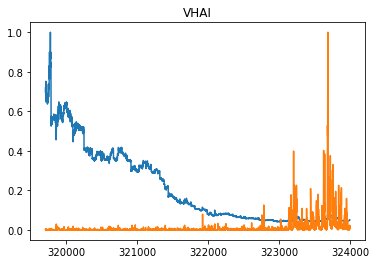

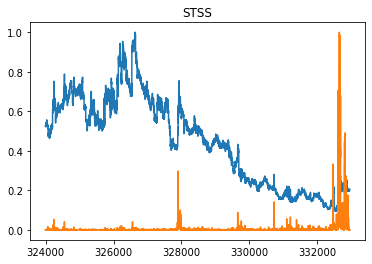

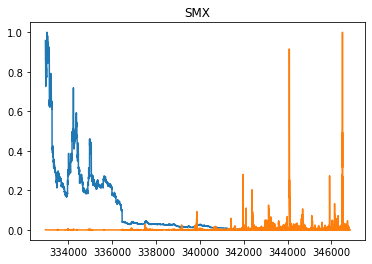

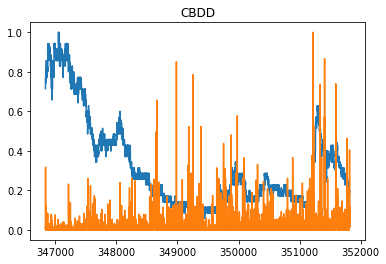

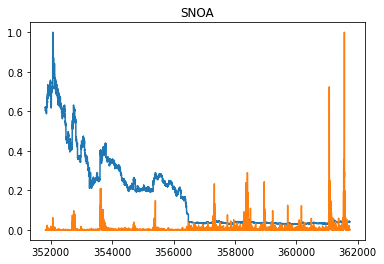

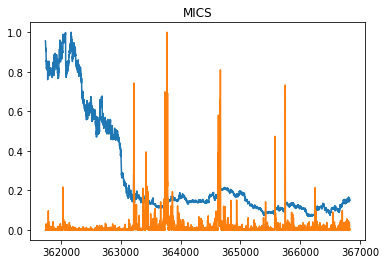

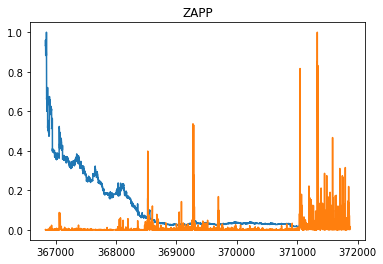

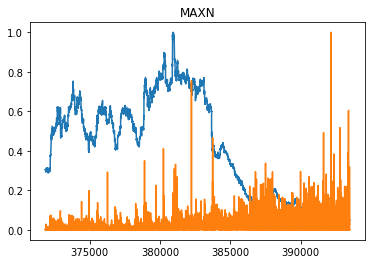

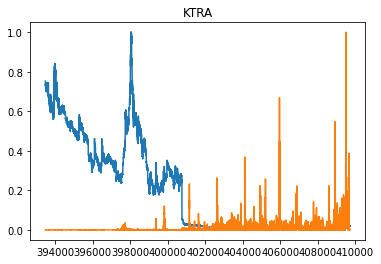

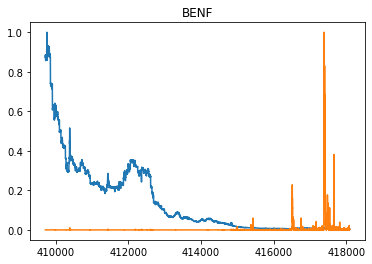

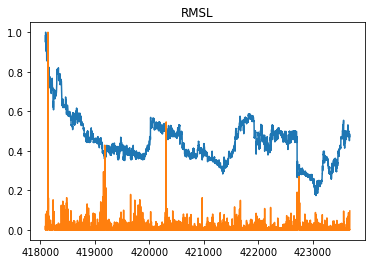

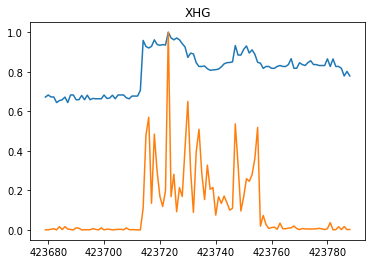

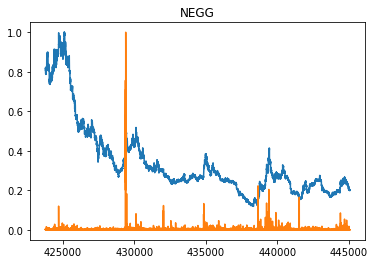

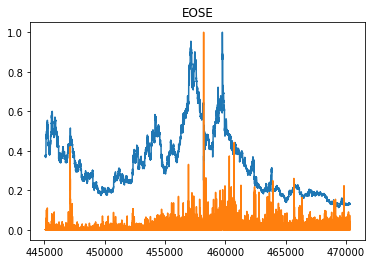

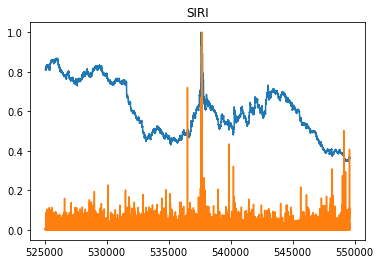

In [11]:

for ticker in data['ticker'].unique():
    tickerD = dataByTicker[ticker]
    plt.plot(tickerD['closeNorm'])
    plt.plot(tickerD['volumeNorm'])
    plt.title(ticker)
    plt.show()
    

# Train on all historical stock data, sequenced

In [ ]:
# Select features to use
features = data[['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']].values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

def create_sequences(data, sequence_length, prediction_length):
    xs, ys = [], []
    index = 0
    count = 0
    while index < len(data) - sequence_length - prediction_length + 1:
        # Check if sequence is within a single day
        if dates[index].date() == dates[index + sequence_length].date() and tickers[index] == tickers[index + sequence_length]:
            # If day == 2024-05-31, print
            # if dates[index] == "2024-05-31":
            # print("We got a sequence from", dates[index], "to", dates[index + sequence_length], "sequence-length is", (index + sequence_length) -index, tickers[index], tickers[index + sequence_length])
            xs.append(data[index:index + sequence_length])
            ys.append(data[index + sequence_length:index + sequence_length + prediction_length, 3])
            index += sequence_length
            count += 1
        else:  # Move index to the start of the next day
            newindex = index
            while dates[newindex].date() == dates[newindex + 1].date():
                newindex += 1
            newindex += 1
            index = newindex
    print("Valid days:", count)
    return np.array(xs), np.array(ys)

# One day sequence lenght
sequence_length = 78
prediction_length = 78
x, y = create_sequences(scaled_features, sequence_length, prediction_length)

train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Split data into train and test sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, x_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(prediction_length))

model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
model.evaluate(x_test, y_test)

# Prediction on unseen 'Real-Time' stock


In [ ]:
# Create Prediction Stock dataset

try:
  query = f"SELECT * FROM all_historical WHERE ticker = 'GSAT';" # *NOTE* Cannot run predictions on EVGN_Predict rn because it has 0 valid days, using GSAT
  cursor.execute(query)
  if cursor.fetchone() is None:
    raise Exception("No results")
  print(f"Success querying EVGN_Predict")
except:
  sys.stderr.write(f"Failed to select EVGN_Predict")

# Turn SQlite Database into Pandas Dataframe
predict_data_whole = pd.read_sql_query(query, sqliteConnection)

# Split into known vs unknown, where unknown is the last 78 entries
split_index_whole = len(predict_data_whole) - 78
known_data_whole = predict_data_whole.iloc[:-78]
unknown_data_whole = predict_data_whole.iloc[-78:]

# Features
known_features = known_data_whole[['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']].values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_known_features = scaler.fit_transform(known_features)



In [ ]:
# Create dates column from miliseconds
dates = pd.to_datetime(known_data_whole['time'], unit='ms')
tickers = known_data_whole['ticker']
dates = dates.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
dates = dates.dt.tz_localize(None)

In [ ]:
# Create Prediction Sequences
sequence_length = 78
prediction_length = 78
x_predict, y_predict = create_sequences(scaled_known_features, sequence_length, prediction_length)

In [ ]:
# Predict with model
predicted_stock_sequence = model.predict(x_predict)

# Evaluate the model
model.evaluate(x_predict, y_predict)

In [ ]:
# Plot results
import matplotlib.pyplot as plt

# Create the combined index for plotting
combined_index = np.arange(len(predict_data_whole))

# Create
plt.figure(figsize=(14, 7))

# Plot
plt.plot(combined_index, predict_data_whole['close'], label='Example "Prediction" Data', color='black', linewidth=3.0)
plt.plot(combined_index[:split_index_whole], known_data_whole['close'], label='"Known" Data', color='cyan', linewidth=2.0, linestyle="--")
plt.plot(combined_index[split_index_whole:], unknown_data_whole['close'], label='"Unknown" Data', color='orange', linewidth=2.0, linestyle="--")
plt.plot(combined_index[split_index_whole:], predicted_stock_sequence[1], label='Model Prediction', color='purple', linewidth=2.0, linestyle="-")

# Format
plt.title('Comparison of Historical, Actual, and Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()

# Adjust y-axis limits based on the data range
# plt.ylim(predict_data_whole.iloc[-200:]['close'].min() - 0.2, predict_data_whole.iloc[-200:]['close'].max() + 0.2)
plt.xlim(len(predict_data_whole) - 200, len(predict_data_whole))  # Crop view to just the very end

# Set y-tick locations with a step of 0.05
# yticks = np.arange(min(predict_data_whole['close']) // 0.05 * 0.05, (max(predict_data_whole['close']) // 0.05 + 1) * 0.05, 0.05)
# plt.yticks(yticks)

plt.show()
